In [ ]:
# Prepare to download from open images
!pip install openimages

from openimages.download import download_dataset

In [1]:
# Mount the drive
from google.colab import drive
import os

classes = ["Balloon", "Barrel", "Sea lion"]
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the files
save_path = "/content/drive/MyDrive/GMM"
os.makedirs(save_path, exist_ok=True)

number_for_samples = 334
print("Downloading is starting...")
download_dataset(save_path, classes, limit=number_for_samples)

drive.flush_and_unmount()

100%|██████████| 200/200 [00:12<00:00, 15.98it/s]


In [2]:
# Create image transformation
import torch
import torchvision
from torchvision.transforms import transforms
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    transforms.ToTensor()
])

In [3]:
import glob
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, class_names, transform):
    self.transform = transform
    self.items = []
    for class_name in class_names:
      class_selection_path = os.path.join(data_dir, class_name.lower(), "images", "*.jpg")
      class_img_paths = glob.glob(class_selection_path)
      for img_path in class_img_paths:
        self.items.append((img_path, class_names.index(class_name)))

  def __len__(self):
    return len(self.items)

  def __getitem__(self, i):
    img_path, class_label = self.items[i]
    img = Image.open(img_path).convert('RGB')
    img = self.transform(img)
    return img, class_label

In [4]:
# Prepare the loader

batch_size = 50
dataset = CustomDataset("/content/drive/MyDrive/GMM", classes, transform)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

class_ids = [417, 427, 150]

In [5]:
# Set up the model
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).to(device)
model.eval()

preprocess = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.2MB/s]


balloon: 60.2%
barrel: 99.9%
sea lion: 53.1%


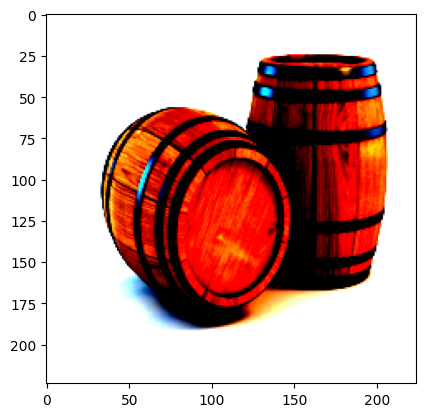

In [30]:
#Test only one image
from PIL import Image

def read_img(file_name):
    img = Image.open(file_name)
    t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
    return t_img.float()

img = read_img("/content/drive/MyDrive/GMM/single/barrels_to_buy.jpg")
output = model(img.to(device))
prediction = torch.sigmoid(output).cpu().detach().numpy()
prediction

for classNr in range(3):
    class_id = class_ids[classNr]
    score = prediction[0][class_id]
    category_name = weights.meta["categories"][class_id]
    print(f"{category_name}: {100 * score:.1f}%")

plt.imshow(img.squeeze().permute(1, 2, 0))

In [6]:
def determineConfusionMatrix(threshold, prediction, class_ids, weights, batch_size):
  tp = [0, 0, 0]
  tn = [0, 0, 0]
  fp = [0, 0, 0]
  fn = [0, 0, 0]
  for imageNr in range(batch_size):
    for classNr in range(3):
      class_id = class_ids[classNr]
      score = prediction[imageNr][class_id]
      category_name = weights.meta["categories"][class_id]
      if score > threshold:
        if test_labels[imageNr] == classNr:
          tp[classNr] += 1
        else:
          fp[classNr] += 1
      else:
        if test_labels[imageNr] != classNr:
          tn[classNr] += 1
        else:
          fn[classNr] += 1

  return tp, tn, fp, fn



In [12]:
def determineConfusionMatrixForOneThreshold(threshold, prediction, class_id, classNr, weights, batch_size):
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  for imageNr in range(batch_size):
    score = prediction[imageNr][class_id]
    category_name = weights.meta["categories"][class_id]
    if score > threshold:
      if test_labels[imageNr] == classNr:
        tp += 1
      else:
        fp += 1
    else:
      if test_labels[imageNr] != classNr:
        tn += 1
      else:
        fn += 1

  return tp, tn, fp, fn

In [7]:
def calculateMetrics(tp, tn, fp, fn):
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  recall = 0 if tp + fn == 0 else tp / (tp + fn) #atkūrimas
  precision = 0 if tp + fp == 0 else tp / (tp + fp) #tikslumas
  f1 = 0 if precision + recall == 0 else 2 * precision * recall / (precision + recall)
  return accuracy, recall, precision, f1


In [29]:
custom_thresholds = [0.8, 0.82, 0.78]
all_tp = [0, 0, 0]
all_tn = [0, 0, 0]
all_fp = [0, 0, 0]
all_fn = [0, 0, 0]
for i in range(math.trunc(1000 / batch_size)):
  # Generate predictions of the new batch
  test_features, test_labels = next(iter(test_dataloader))
  output = model(test_features.to(device))
  prediction = torch.sigmoid(output).cpu().detach().numpy()
  for classNr in range(3):
    tp, tn, fp, fn = determineConfusionMatrixForOneThreshold(custom_thresholds[classNr], prediction, class_ids[classNr], classNr, weights, batch_size)
    all_tp[classNr] += tp
    all_tn[classNr] += tn
    all_fp[classNr] += fp
    all_fn[classNr] += fn

for classNr in range(3):
  accuracy, recall, precision, f1 = calculateMetrics(all_tp[classNr], all_tn[classNr], all_fp[classNr], all_fn[classNr])
  print("Class: " + classes[classNr] + " | Threshold: " + str(custom_thresholds[classNr]) + " | Accuracy: " + str(accuracy) + " | Recall: " + str(recall) + " | Precision: " + str(precision) + " | F1: " + str(f1))


Class: Balloon | Threshold: 0.8 | Accuracy: 0.941 | Recall: 0.9263392857142857 | Precision: 0.9410430839002267 | F1: 0.9336332958380202
Class: Barrel | Threshold: 0.82 | Accuracy: 0.933 | Recall: 0.85 | Precision: 0.9205776173285198 | F1: 0.8838821490467939
Class: Sea lion | Threshold: 0.78 | Accuracy: 0.954 | Recall: 0.8333333333333334 | Precision: 0.9813084112149533 | F1: 0.9012875536480688


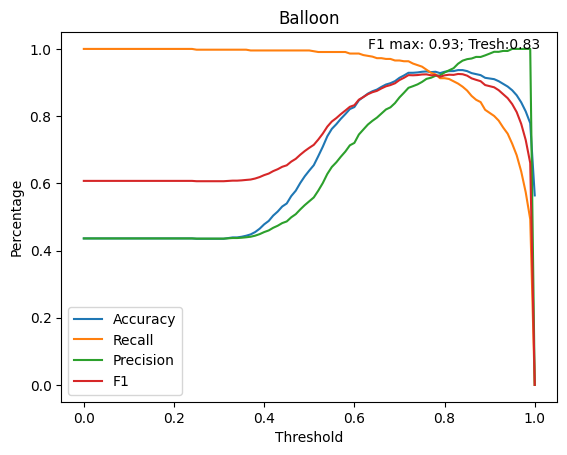

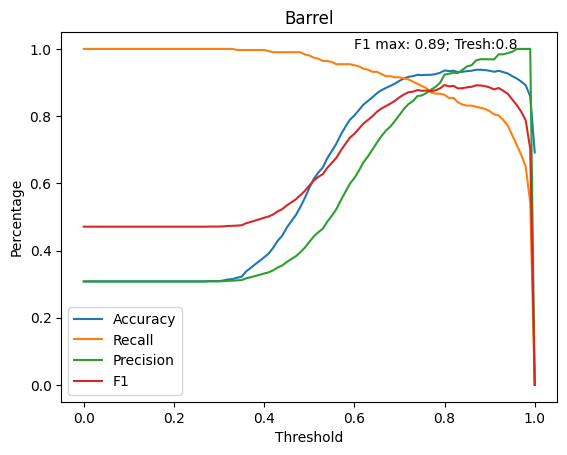

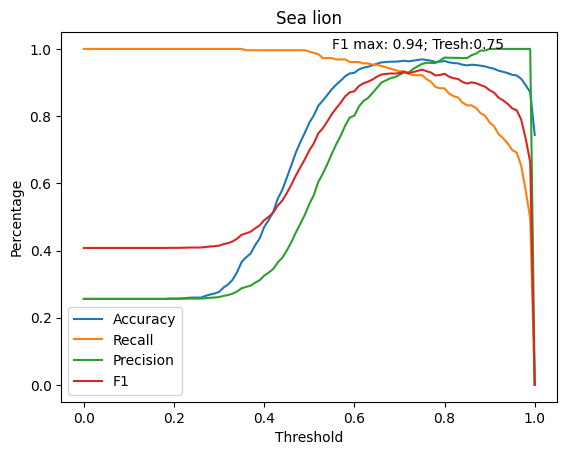

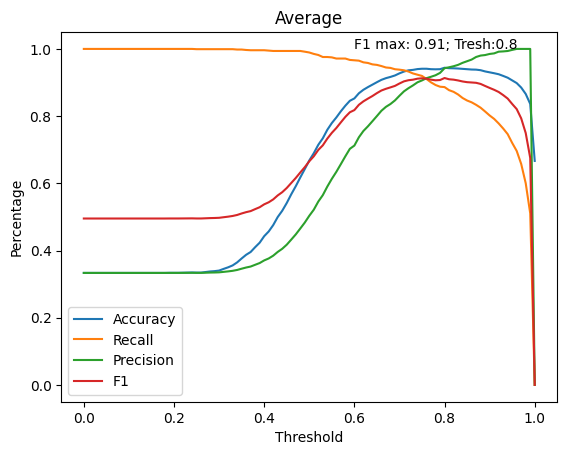

In [26]:
import matplotlib.pyplot as plt
import math
import numpy

accuracy_data = [[], [], [], []]
recall_data = [[], [], [], []]
precision_data = [[], [], [], []]
f1_data = [[], [], [], []]

tp_data = []
tn_data = []
fp_data = []
fn_data = []

for i in range(101):
  tp_data.append([0, 0, 0])
  tn_data.append([0, 0, 0])
  fp_data.append([0, 0, 0])
  fn_data.append([0, 0, 0])

threshold_values = [i / 100 for i in range(101)]

for i in range(math.trunc(1000 / batch_size)):
  # Generate predictions of the new batch
  test_features, test_labels = next(iter(test_dataloader))
  output = model(test_features.to(device))
  prediction = torch.sigmoid(output).cpu().detach().numpy()

  # Determine batch confusion matrix and add to total

  for threshold in range(101):
    tp, tn, fp, fn = determineConfusionMatrix(threshold / 100, prediction, class_ids, weights, batch_size)

    for classNr in range(3):
      tp_data[threshold][classNr] += tp[classNr]
      tn_data[threshold][classNr] += tn[classNr]
      fp_data[threshold][classNr] += fp[classNr]
      fn_data[threshold][classNr] += fn[classNr]

# Calculate all metrics
for threshold in range(101):

  average_accuracy = 0
  average_recall = 0
  average_precision = 0
  average_f1 = 0

  for classNr in range(3):
      accuracy, recall, precision, f1 = calculateMetrics(tp_data[threshold][classNr], tn_data[threshold][classNr], fp_data[threshold][classNr], fn_data[threshold][classNr])
      average_accuracy += accuracy
      average_recall += recall
      average_precision += precision
      average_f1 += f1

      accuracy_data[classNr].append(accuracy)
      recall_data[classNr].append(recall)
      precision_data[classNr].append(precision)
      f1_data[classNr].append(f1)

  accuracy_data[3].append(average_accuracy / 3)
  recall_data[3].append(average_recall / 3)
  precision_data[3].append(average_precision / 3)
  f1_data[3].append(average_f1 / 3)

# Plot the results
for classNr in range(4):
  plt.title("Average" if classNr == 3 else classes[classNr])
  plt.plot(threshold_values, accuracy_data[classNr], label="Accuracy")
  plt.plot(threshold_values, recall_data[classNr], label="Recall")
  plt.plot(threshold_values, precision_data[classNr], label="Precision")
  plt.plot(threshold_values, f1_data[classNr], label="F1")
  F1xmax = threshold_values[numpy.argmax(f1_data[classNr])]
  F1ymax = round(max(f1_data[classNr]),2)
  plt.annotate("F1 max: " + str(F1ymax) + "; Tresh:" + str(F1xmax), xy=(F1xmax, F1ymax), xytext=(F1xmax - 0.2, 1.0))
  plt.legend(loc="best")
  plt.xlabel('Threshold')
  plt.ylabel('Percentage')
  plt.show()
